In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
from qutip import *
import time
import pandas as pd
from itertools import combinations, permutations, chain
from copy import deepcopy
from math import factorial

In [2]:
plt.rcParams.update({'font.size': 12})

## Function

### G Correlation

In [3]:
def Gcal(sn, ind):
    si = qeye(2)
    slist=[]
    for i in range(1,len(ind)+1):
        slist=slist+[list(x) for x in combinations(ind, i)]

    out = {}
    for k in slist:
        Tens = []
        for n in range(N-max(ind)):
            op_list = []
            for m in range(N):
                op_list.append(si)
            for i in k:
                op_list[n+i] = sn[i]
            Tens.append(tensor(op_list))
        out[str(k)]=Tens
    return out

In [4]:
# https://stackoverflow.com/questions/39192777/how-to-split-a-list-into-n-groups-in-all-possible-combinations-of-group-length-a
def slice_by_lengths(lengths, the_list):
    for length in lengths:
        new = []
        for i in range(length):
            new.append(the_list.pop(0))
        yield new

def partition(number):
    return {(x,) + y for x in range(1, number) for y in partition(number-x)} | {(number,)}

def subgrups(my_list):
    partitions = partition(len(my_list))
    permed = []
    for each_partition in partitions:
        permed.append(set(permutations(each_partition, len(each_partition))))

    for each_tuple in chain(*permed):
        yield list(slice_by_lengths(each_tuple, deepcopy(my_list)))
        
def return_partition(my_list,num_groups):
    filtered=[]
    for perm in permutations(my_list,len(my_list)):
        for sub_group_perm in subgrups(list(perm)):
            if len(sub_group_perm)==num_groups:
                #sort  within each partition
                sort1=[sorted(i) for i in sub_group_perm]
                #sort by first element of each partition
                sort2=sorted(sort1, key=lambda t:t[0])
                #sort by the number of elements in each partition
                sort3=sorted(sort2, key=lambda t:len(t))
                #if this new sorted set of partitions has not been added, add it
                if sort3 not in filtered:
                    filtered.append(sort3)
    return filtered

In [5]:
def CalGcorrelation(CorMea_i,val):
    ind = [n for n in range(len(CorMea_i)) if CorMea_i[n]!=None]
#     print(ind)
    TotalG = 0
    for gn in range(len(ind)):
#         print(gn)
    # factorial()
        fac = (-1)**(gn)*factorial(gn)
        keys = return_partition(ind,gn+1)
        gsum=0
        for key in keys:
            mul=1
#             print('hi')
            for nv,lis in enumerate(key):
                mul = mul*val[str(lis)]
            gsum += mul
        TotalG += fac*gsum
    return TotalG

In [6]:
def Analyze(_ResExp, _CorMea):
    ResAna=[None]*len(Nran)
    for NumNran in range(len(Nran)):
        ResAna[NumNran]=[None]*len(_CorMea)
        for MIter,ResK in enumerate(_ResExp[NumNran]):
            ResAna[NumNran][MIter]={}
            if len(ResK)>1:
                ResAna[NumNran][MIter]['Cor'] = CalGcorrelation(_CorMea[MIter],ResK)
                ResAna[NumNran][MIter]['Avg'] = ResAna[NumNran][MIter]['Cor'].mean(axis=0)
            else:
                for k,v in ResK.items():
                    ResAna[NumNran][MIter]['Cor'] = v
                    ResAna[NumNran][MIter]['Avg'] = v.mean(axis=0)
    return ResAna

### Integrate H

In [7]:
def integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea,gCal=None, StateOut=False):

    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    snMea_list = [None]*len(CorMea)

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        
        op_list[n] = sx
        sx_list.append( tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

    for l,m in enumerate(CorMea):
        snMea_list[l] = {}
        sn = [s.data[0,0]*sx+s.data[1,0]*sy+s.data[2,0]*sz if s is not None else None for s in m]
        ind = [i for i in range(len(sn)) if sn[i]!=None]

        if gCal is not None and gCal[l]:
            snMea_list[l] = Gcal(sn,ind)
        else:
            Tens = []
            for n in range(N-len(sn)+1):
                op_list = []
                for m in range(N):
                    op_list.append(si)
                for j in ind:
                    op_list[n+j] = sn[j]
                Tens.append(tensor(op_list))
            snMea_list[l][str(ind)]=Tens

    # construct the hamiltonian
    H = 0

    # energy splitting terms
    for n in range(N):
        H += 0.5 * Bz[n] * sz_list[n]
        H += 0.5 * Bx[n] * sx_list[n]
        
        
    # interaction terms
    for n in range(N-1):
        H += 0.25 * Jx[n] * sx_list[n] * sx_list[n+1]
        H += 0.25 * Jy[n] * sy_list[n] * sy_list[n+1]
        H += 0.25 * Jz[n] * sz_list[n] * sz_list[n+1]

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])
    
    # evolve and calculate expectation values
    if solver == "me":

        if StateOut:
            results = np.array(mesolve(H, psi0, tlist, c_op_list).states,dtype=object)
        else:
            results = np.empty(len(snMea_list),dtype=object)
            for i,j in enumerate(snMea_list):
                results[i]={}
                for k,opers in j.items():
                    results[i][k]=np.array(mesolve(H, psi0, tlist, c_op_list, opers).expect)

    elif solver == "mc":
        ntraj = 250 
        results = mcsolve(H, psi0, tlist, c_op_list, MB, ntraj)

    return (results)

## Main

In [8]:
# constance setting
x = Qobj([[1],[0],[0]]).unit()
y = Qobj([[0],[1],[0]]).unit()
z = Qobj([[0],[0],[1]]).unit()
solver = "me"   # use the ode solver

### Clean case

In [9]:
start_time = time.time()
N = 3            # number of spins
CorMea = [
            [y],
            [y,y],
            [z,y,z],
            [y,None,y],
            [y,y,y],
         ]
gCal = [0,1,0,1,1]
Nran = np.random.rand(1)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i+1,end='')
    Bx = 0.0 * 2 *np.pi * np.ones(N)
    Bz = 0.0 * 2 *np.pi * np.ones(N)
    Jz = 1.0 * 2 *np.pi * np.ones(N)
    Jx = 0.0 * 2 *np.pi * np.ones(N)
    Jy = 0.0 * 2 *np.pi * np.ones(N)
    # dephasing rate
    gamma = 0.00 * np.ones(N)
    # intial state
    psi_list = []
    for n in range(N):
#         psi_list.append(basis(2,0)) #up |0>
#         psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>
    psi0 = tensor(psi_list)
    # time
    tlist = np.linspace(0, 2, 500) # 2*Pi unit
    # solve
    ResExp[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea, gCal)
print("--- %0.4f seconds ---" % (time.time() - start_time))

--- 0.5481 seconds ---


In [10]:
# Analysis part
tlist_pi = tlist*2 # 2*pi to pi unit
ResAna = Analyze(ResExp, CorMea)

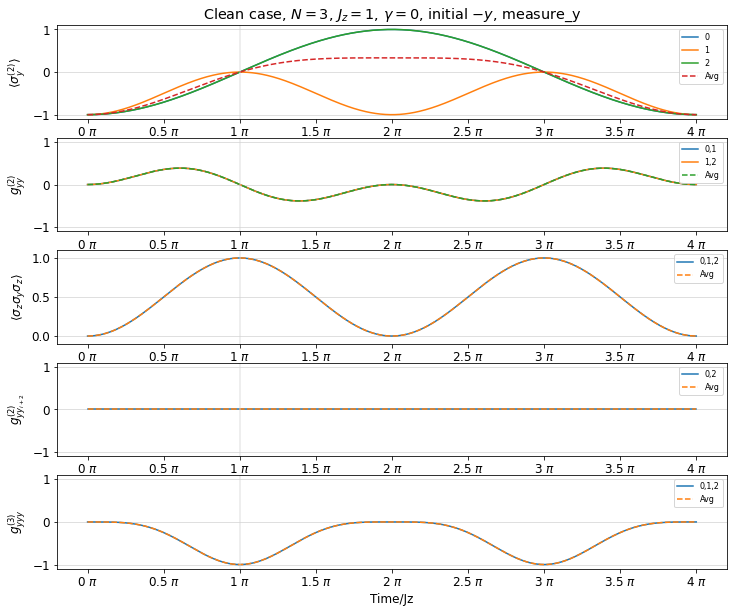

In [11]:
fig, axs = plt.subplots(5,1,figsize=(12,10))

Res0 = ResAna[0][0]['Cor']
Res0_avg = ResAna[0][0]['Avg']
for n in range(len(Res0)):
    axs[0].plot(tlist_pi, Res0[n],label=n)

Res1 = ResAna[0][1]['Cor']
Res1_avg = ResAna[0][1]['Avg']
for n in range(len(Res1)):
    axs[1].plot(tlist_pi, Res1[n],label=str(n)+','+str(n+1))

Res2 = ResAna[0][2]['Cor']
Res2_avg = ResAna[0][2]['Avg']
for n in range(len(Res2)):
    axs[2].plot(tlist_pi, Res2[n],label=str(n)+','+str(n+1)+','+str(n+2))
    
Res3 = ResAna[0][3]['Cor']
Res3_avg = ResAna[0][3]['Avg']
for n in range(len(Res3)):
    axs[3].plot(tlist_pi, Res3[n],label=str(n)+','+str(n+2))

Res4 = ResAna[0][4]['Cor']
Res4_avg = ResAna[0][4]['Avg']
for n in range(len(Res4)):
    axs[4].plot(tlist_pi, Res4[n],label=str(n)+','+str(n+1)+','+str(n+2))

axs[0].plot(tlist_pi, Res0_avg,'--',label='Avg')
axs[1].plot(tlist_pi, Res1_avg,'--',label='Avg')
axs[2].plot(tlist_pi, Res2_avg,'--',label='Avg')
axs[3].plot(tlist_pi, Res3_avg,'--',label='Avg')
axs[4].plot(tlist_pi, Res4_avg,'--',label='Avg')

axs[4].set_xlabel('Time/Jz')
axs[0].set_ylabel(r'$\langle\sigma_y^{(2)}\rangle$')
axs[1].set_ylabel(r'$g^{(2)}_{yy}$')
axs[2].set_ylabel(r'$\langle \sigma_z\sigma_y\sigma_z\rangle$')
axs[3].set_ylabel(r'$g^{(2)}_{yy_{i+2}}$')
axs[4].set_ylabel(r'$g^{(3)}_{yyy}$')

axs[0].set_title('Clean case, $N=3$, $J_z=1$, $\gamma=0$, initial $-y$, measure_y');
axs[0].set_ylim([-1.1,1.1])
axs[1].set_ylim([-1.1,1.1])
axs[2].set_ylim([-0.1,1.1])
axs[3].set_ylim([-1.1,1.1])
axs[4].set_ylim([-1.1,1.1])

for ax in axs:
    ax.legend(fontsize=8)
    ax.grid(axis = 'y', alpha=.5)
    ax.axvline(x=1,color='lightgray', alpha=.5)
#     ax.xaxis.set_ticklabels([])
    ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    ax.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
fig.savefig('Outputs/New_N3_vs_N5/'+'Clean_N=3_Jz=1_gamma=0_initial-y_measure_y.png', dpi=100)

### Apply global phase $B_z$

#### Measurement $\langle \sigma_y \rangle$

In [ ]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 6            # number of spins

Sbasis = Qobj([[0],[1],[0]]).unit() #sigmax, sigmay, sigmaz
CorMea = [
            [Sbasis,Sbasis],
            [Sbasis],
            [Qobj([[0],[0],[1]]),Sbasis,Qobj([[0],[0],[1]])],
         ]

Nran = np.random.rand(300)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i+1,end='')
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 1.0 * np.ones(N)*(rani)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
#         psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 12, 500)
    # 
    ResExp[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea)
print("--- %0.4f seconds ---" % (time.time() - start_time))

 300--- 59.5053 seconds ---


(-1.1, 1.1)

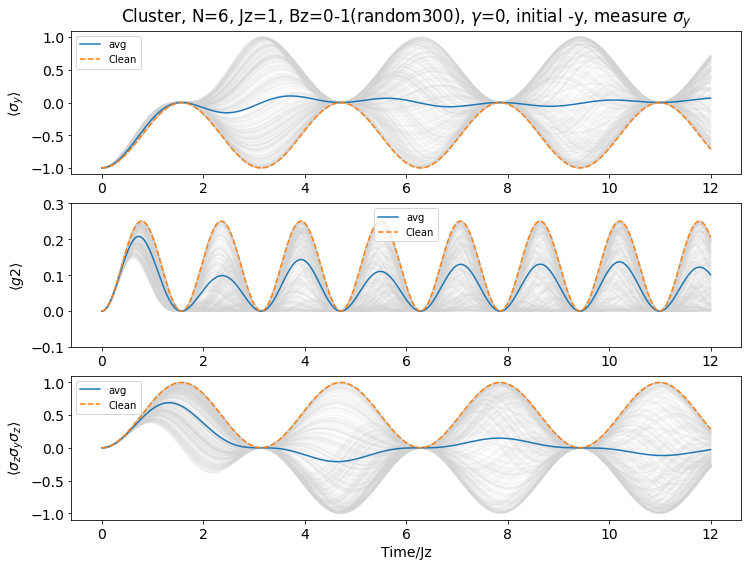

In [ ]:
ReSide = 1

g2=np.empty(len(Nran), dtype=object)
Meas=np.empty(len(Nran), dtype=object)
K=np.empty(len(Nran), dtype=object)
for i in range(len(Nran)):
    Meas[i] = ResExp[i][1][ReSide:N-ReSide]
    g2[i] = ResExp[i][0][ReSide:N-1-ReSide]-ResExp[i][1][ReSide:N-1-ReSide]*ResExp[i][1][1+ReSide:N-ReSide]
    K[i] = ResExp[i][2][ReSide:N-2-ReSide]
MeasAvg = Meas.mean(axis=0).mean(axis=0)
g2Avg = g2.mean(axis=0).mean(axis=0)
KAvg = K.mean(axis=0).mean(axis=0)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))

for n in range(len(Meas)):
    ax1.plot(tlist, Meas[n][0],'lightgray', alpha=.1)
ax1.plot(tlist, MeasAvg,'-', label='avg')
ax1.plot(tlist, MeasAvgClean,'--', label='Clean')


for n in range(len(g2)):
    ax2.plot(tlist, g2[n][0],'lightgray', alpha=.1)
ax2.plot(tlist, g2Avg,'-', label='avg')
ax2.plot(tlist, g2AvgClean,'--', label='Clean')

for n in range(len(K)):
    ax3.plot(tlist, K[n][0],'lightgray', alpha=.1)
ax3.plot(tlist, KAvg, '-', label='avg')
ax3.plot(tlist, KAvgClean,'--', label='Clean')

ax1.legend(fontsize=10)
ax2.legend(fontsize=10)
ax3.legend(fontsize=10)
ax3.set_xlabel('Time/Jz')
ax1.set_ylabel(r'$\langle\sigma_y\rangle$')
ax2.set_ylabel(r'$\langle g2\rangle$')
ax3.set_ylabel(r'$\langle \sigma_z\sigma_y\sigma_z\rangle$')

ax1.set_title('Cluster, N=6, Jz=1, Bz=0-1(random300), $\gamma$=0, initial -y, measure $\sigma_y$');
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-0.1,0.3])
ax3.set_ylim([-1.1,1.1])

# fig.savefig('Outputs/ClusterCorr/'+'Cluster_N=6_Jz=1_Bz=0-1(random300)_gamma=0_initial-y_measure_sigma_y_dpi100.png', dpi=100)

#### Measurement $\langle \sigma_x \rangle$

In [503]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 6            # number of spins

Sbasis = Qobj([[1],[0],[0]]).unit() #sigmax, sigmay, sigmaz
CorMea = [
            [Sbasis,Sbasis],
            [Sbasis],
            [Qobj([[0],[0],[1]]),Sbasis,Qobj([[0],[0],[1]])],
         ]

Nran = np.random.rand(50)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i+1,end='')
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 1.0 * np.ones(N)*(rani)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
#         psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 12, 500)
    # 
    ResExp[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea)
print("--- %0.4f seconds ---" % (time.time() - start_time))

 50--- 11.0450 seconds ---


NameError: name 'KAvgClean' is not defined

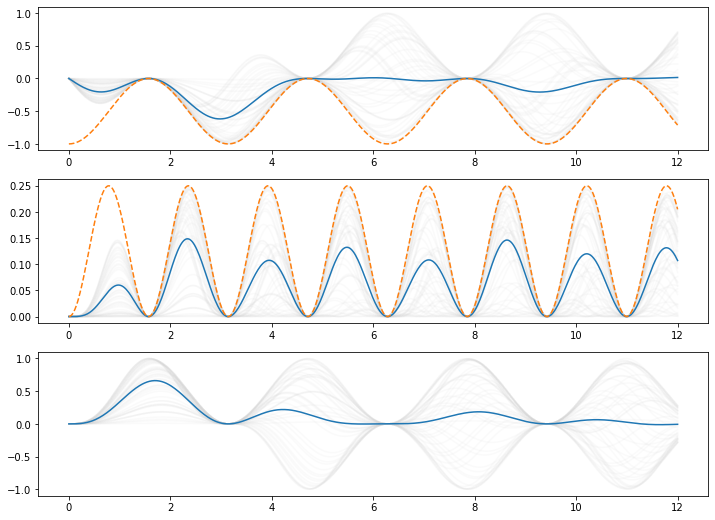

In [504]:
ReSide = 1

g2=np.empty(len(Nran), dtype=object)
Meas=np.empty(len(Nran), dtype=object)
K=np.empty(len(Nran), dtype=object)
for i in range(len(Nran)):
    Meas[i] = ResExp[i][1][ReSide:N-ReSide]
    g2[i] = ResExp[i][0][ReSide:N-1-ReSide]-ResExp[i][1][ReSide:N-1-ReSide]*ResExp[i][1][1+ReSide:N-ReSide]
    K[i] = ResExp[i][2][ReSide:N-2-ReSide]
MeasAvg = Meas.mean(axis=0).mean(axis=0)
g2Avg = g2.mean(axis=0).mean(axis=0)
KAvg = K.mean(axis=0).mean(axis=0)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))

for n in range(len(Meas)):
    ax1.plot(tlist, Meas[n][0],'lightgray', alpha=.1)
ax1.plot(tlist, MeasAvg,'-', label='avg')
ax1.plot(tlist, MeasAvgClean,'--', label='Clean')


for n in range(len(g2)):
    ax2.plot(tlist, g2[n][0],'lightgray', alpha=.1)
ax2.plot(tlist, g2Avg,'-', label='avg')
ax2.plot(tlist, g2AvgClean,'--', label='Clean')

for n in range(len(K)):
    ax3.plot(tlist, K[n][0],'lightgray', alpha=.1)
ax3.plot(tlist, KAvg, '-', label='avg')
ax3.plot(tlist, KAvgClean,'--', label='Clean')

ax1.legend(fontsize=10)
ax2.legend(fontsize=10)
ax3.legend(fontsize=10)
ax3.set_xlabel('Time/Jz')
ax1.set_ylabel(r'$\langle\sigma_x\rangle$')
ax2.set_ylabel(r'$\langle g2\rangle$')
ax3.set_ylabel(r'$\langle \sigma_z\sigma_x\sigma_z\rangle$')

ax1.set_title('Cluster, N=6, Jz=1, Bz=1(random300), $\gamma$=0, initial -y, measure $\sigma_x$');
ax1.set_ylim([-1.1,1.1])
ax2.set_ylim([-0.1,0.3])
ax3.set_ylim([-1.1,1.1])

# fig.savefig('Outputs/ClusterCorr/'+'Cluster_N=6_Jz=1_Bz=1(random300)_gamma=0_initial-y_measure_sigma_x.png', dpi=300)

## Check states

In [222]:
start_time = time.time()
solver = "me"   # use the ode solver
N = 4            # number of spins


Sets = [(basis(2, 0) + basis(2, 1)).unit(),    # |x>
        (basis(2, 0) - basis(2, 1)).unit(),    # |-x>
        (basis(2, 0) + 1j*basis(2, 1)).unit(), # |y>
        (basis(2, 0) - 1j*basis(2, 1)).unit(), # |-y>
       ]
ResSta = np.empty(len(Sets), dtype=object)
for i,Set in enumerate(Sets):
    if (i+1)%10 == 0:
        print('\r',i,end='')
        
    Sbasis = Qobj([[1],[0],[0]]).unit() #sigmax, sigmay, sigmaz
    CorMea = [
                [y,y],
                [y],
             ]
    gCal = [0,1]
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * 2 *np.pi * np.ones(N)
    Bz = 0.0 * 2 *np.pi * np.ones(N)
    Jz = 1.0 * 2 *np.pi * np.ones(N)
    Jx = 0.0 * 2 *np.pi * np.ones(N)
    Jy = 0.0 * 2 *np.pi * np.ones(N)
    # dephasing rate
    gamma = 0.0 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
#         psi_list.append(basis(2,0)) #up |0>
        psi_list.append(Set) # |x>
#         psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 1, 200)
    # 
    ResSta[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea, gCal, StateOut=True)
print("--- %0.4f seconds ---" % (time.time() - start_time))

--- 0.1436 seconds ---


In [58]:
# Pi half pulse
PiHalf = 1/np.sqrt(2)*(qeye(2)-1j*sigmax())
PiHalf*ket2dm(basis(2, 0))*PiHalf.dag()
# *basis(2, 0)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]

### Quantify the entanglement
The concurrent &C& is two particle used to certify entanglement. $C=1$ is maximally entangled states while $C=0$ is separable states.

Concurrent is epressed by 
$$C_{mn}(t)=max\left \{ 0 , 2\lambda(t)-\sum_{k=1}^4\lambda_k(t) \right \}$$
, where $$\lambda(t)=max\left \{\lambda_1(t),\lambda_2(t),\lambda_3(t),\lambda_4(t)\right \}$$
and $\lambda_1, \lambda_2, \lambda_3, \lambda_4$ are squrt roots of eigenvakues of the product
$$R_{mn}(t)=\rho_{mn}(t)\tilde{\rho}_{mn}(t)$$
with
$$\tilde{\rho}_{mn}(t)=Q\rho_{mn}(t)Q$$
and $$Q = \begin{bmatrix}
0 & 0 & 0 & -1\\ 
0 & 0 & 1 & 0\\ 
0 & 1 & 0 & 0\\ 
-1 & 0 & 0 & 0
\end{bmatrix}$$

$\rho_{mn}(t)$ is reduced density matrix $\rho_{mn}(t)= Tr_{mn}(\rho_{rot}(t))$.

[Ref](https://arxiv.org/ftp/arxiv/papers/0805/0805.3396.pdf)

In [225]:
def project(vec,OperProj):
    si = qeye(2)
    op_list = []
    for m in range(N):
        op_list.append(si)
    op_list1 = op_list.copy()
    op_list1[0] = OperProj[0]
    op_list4 = op_list.copy()
    op_list4[3] = OperProj[1]
    proj1 = tensor(op_list1)
    proj4 = tensor(op_list4)

    return [((proj1*ket2dm(n)*proj4).ptrace([1,2])).unit() for n in vec]

def conc(den):
    q = tensor(1j*sigmay(),-1j*sigmay())
    r = [i*q*i.conj()*q for i in den]
    c = []
    for n in r:
        try:
            lamb = n.eigenstates()[0]
            c.append(np.real(max(0,2*np.sqrt(lamb).max()-np.sum(lamb))))
        except:
            c.append(0)
    return c

In [226]:
ProjBasis = {
            'ZZ' : [(sigmap()*sigmam()).unit(),(sigmap()*sigmam()).unit()],
            'zz' : [(sigmam()*sigmap()).unit(),(sigmam()*sigmap()).unit()],
            'Zz' : [(sigmap()*sigmam()).unit(),(sigmam()*sigmap()).unit()],
            'zZ' : [(sigmam()*sigmap()).unit(),(sigmap()*sigmam()).unit()],
            
            'XX' : [(qeye(2)+sigmax()).unit(),(qeye(2)+sigmax()).unit()],
            'xx' : [(qeye(2)-sigmax()).unit(),(qeye(2)-sigmax()).unit()],
            'Xx' : [(qeye(2)+sigmax()).unit(),(qeye(2)-sigmax()).unit()],
            'xX' : [(qeye(2)-sigmax()).unit(),(qeye(2)+sigmax()).unit()],
    
            'YY' : [(qeye(2)+1*sigmay()).unit(),(qeye(2)+1*sigmay()).unit()],
            'yy' : [(qeye(2)-1*sigmay()).unit(),(qeye(2)-1*sigmay()).unit()],
            'Yy' : [(qeye(2)+1*sigmay()).unit(),(qeye(2)+1*sigmay()).unit()],
            'yY' : [(qeye(2)+1*sigmay()).unit(),(qeye(2)+1*sigmay()).unit()],
    
#             'ZY' : [(sigmap()*sigmam()).unit(),(qeye(2)+1*sigmay()).unit()],
#             'YZ' : [(qeye(2)+1*sigmay()).unit(),(sigmap()*sigmam()).unit()],
#             'zy' : [(sigmam()*sigmap()).unit(),(qeye(2)-1*sigmay()).unit()],
#             'yz' : [(qeye(2)-1*sigmay()).unit(),(sigmam()*sigmap()).unit()],
#             'Zy' : [(sigmap()*sigmam()).unit(),(qeye(2)-1*sigmay()).unit()],
#             'yZ' : [(qeye(2)-1*sigmay()).unit(),(sigmap()*sigmam()).unit()],
#             'zY' : [(sigmam()*sigmap()).unit(),(qeye(2)+1*sigmay()).unit()],
#             'Yz' : [(qeye(2)+1*sigmay()).unit(),(sigmam()*sigmap()).unit()],
}

Results = {}
for key, value in ProjBasis.items():
    Results[key]={}
    reduce = [project(n,value) for n in ResSta]
    Results[key]['Reduce'] = reduce
    Results[key]['Conc'] = np.array([conc(n) for n in reduce])

# initial state and measurement
# [0] -> |x>, Sx
# [1] -> |-x>, Sx
# [2] -> |y>, Sy
# [3] -> |-y>, Sy

c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\scipy\sparse\base.py:583: RuntimeWarning: divide by zero encountered in double_scalars
  r = self._mul_scalar(1./other)
c:\users\admin\appdata\local\programs\python\python39\lib\site-packages\scipy\sparse\data.py:124: RuntimeWarning: invalid value encountered in multiply
  return self._with_data(self.data * other)


(-0.1, 1.1)

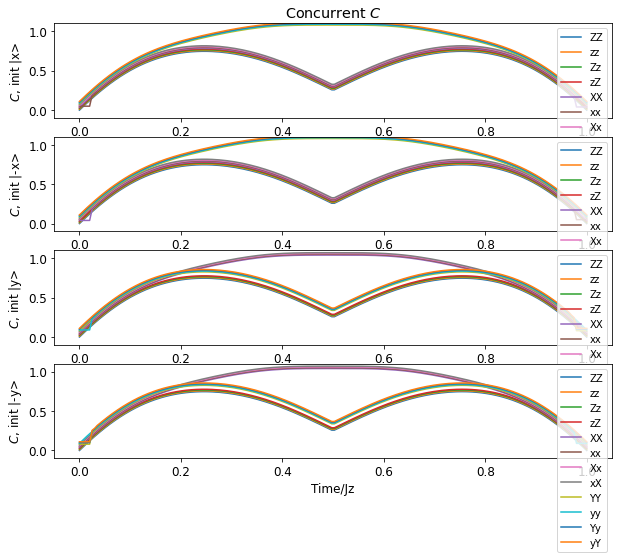

In [193]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,8))
for i,key in enumerate(ProjBasis.keys()):
    for n in range(len(Results[key]['Conc'])):
        if n==0:
            ax1.plot(tlist, Results[key]['Conc'][n]+i*0.01,label=key)
        if n==1:
            ax2.plot(tlist, Results[key]['Conc'][n]+i*0.01,label=key)
        if n==2:
            ax3.plot(tlist, Results[key]['Conc'][n]+i*0.01,label=key)
        if n==3:
            ax4.plot(tlist, Results[key]['Conc'][n]+i*0.01,label=key)

ax1.legend(fontsize=10)
ax2.legend(fontsize=10)
ax3.legend(fontsize=10)
ax4.legend(fontsize=10)
ax4.set_xlabel('Time/Jz')
ax1.set_ylabel(r'$C$, init |x>')
ax2.set_ylabel(r'$C$, init |-x>')
ax3.set_ylabel(r'$C$, init |y>')
ax4.set_ylabel(r'$C$, init |-y>')

ax1.set_title('Concurrent $C$');
ax1.set_ylim([-0.1,1.1])
ax2.set_ylim([-0.1,1.1])
ax3.set_ylim([-0.1,1.1])
ax4.set_ylim([-0.1,1.1])

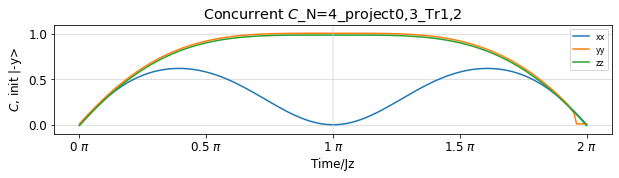

In [228]:
fig, (ax1) = plt.subplots(1,1,figsize=(10,2))
ax1.plot(tlist*2, Results['xx']['Conc'][3],label='xx')
ax1.plot(tlist*2, Results['yy']['Conc'][3]+0.01,label='yy')
ax1.plot(tlist*2, Results['zz']['Conc'][3]-0.01,label='zz')

ax1.legend(fontsize=10)
ax1.set_xlabel('Time/Jz')
ax1.set_ylabel(r'$C$, init |-y>')

ax1.set_title('Concurrent $C$_N=4_project0,3_Tr1,2');
ax1.set_ylim([-0.1,1.1])

ax1.legend(fontsize=8)
ax1.grid(axis = 'y', alpha=.5)
ax1.axvline(x=1,color='lightgray', alpha=.5)
ax1.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
ax1.xaxis.set_major_locator(tck.MultipleLocator(base=0.5))
# fig.savefig('Outputs/Basis_projection/'+'Concurrent_N=4_project0,3_Tr1,2.png', dpi=100)

### Summarize
- check state at $t = \pi$

Bell's states
- $\Psi^\pm=\frac{|00>\pm|11>}{\sqrt{2}}$
- $\Phi^\pm=\frac{|01>\pm|10>}{\sqrt{2}}$

#### Init on y axis
| Projects (1,4) $(\rho_{init=-y})$| Projects (1,4) $(\rho_{init=+y})$ | State of middle pair $(\rho^{3,4})$ | Expand |Concurrent $C$|
| --- | --- | --- | --- | :-: |
|$$Y^{(1)}\rho Y^{(4)}$$       |$$Y^{(1)}\rho Y^{(4)}$$       | $$\frac{\Psi^-+\Phi^+}{\sqrt{2}}$$  | $$0.5(|00\rangle+|01\rangle+|10\rangle-|11\rangle)$$  |1|
|$$(-Y^{(1)})\rho (-Y^{(4)})$$ |$$(-Y^{(1)})\rho (-Y^{(4)})$$ | $$\frac{\Psi^--\Phi^+}{\sqrt{2}}$$  | $$0.5(|00\rangle-|01\rangle-|10\rangle-|11\rangle)$$  |1|
|$$Y^{(1)}\rho (-Y^{(4)})$$    |$$Y^{(1)}\rho (-Y^{(4)})$$    | $$\frac{\Psi^-+\Phi^+}{\sqrt{2}}$$  | $$0.5(|00\rangle+|01\rangle+|10\rangle-|11\rangle)$$  |1|
|$$(-Y^{(1)})\rho Y^{(4)}$$    |$$(-Y^{(1)})\rho Y^{(4)}$$    | $$\frac{\Psi^-+\Phi^+}{\sqrt{2}}$$  | $$0.5(|00\rangle+|01\rangle+|10\rangle-|11\rangle)$$  |1|
||
|$$X^{(1)}\rho X^{(4)}$$       |$$(-X^{(1)})\rho (-X^{(4)})$$ | $$\frac{\Psi^+-\Psi^-}{\sqrt{2}}$$  | $$|11\rangle$$                                         |0|
|$$(-X^{(1)})\rho (-X^{(4)})$$ |$$X^{(1)}\rho X^{(4)}$$       | $$\frac{\Psi^++\Psi^-}{\sqrt{2}}$$  | $$|00\rangle$$                                         |0|
|$$X^{(1)}\rho (-X^{(4)})$$    |$$(-X^{(1)})\rho X^{(4)}$$    | $$\frac{\Phi^+-\Phi^-}{\sqrt{2}}$$  | $$|10\rangle$$                                         |0|
|$$(-X^{(1)})\rho X^{(4)}$$    |$$X^{(1)}\rho (-X^{(4)})$$    | $$\frac{\Phi^++\Phi^-}{\sqrt{2}}$$  | $$|01\rangle$$                                         |0|
||
|$$Z^{(1)}\rho Z^{(4)}$$       |$$(-Z^{(1)})\rho (-Z^{(4)})$$ | $$\frac{\Psi^++i\Phi^+}{\sqrt{2}}$$ | $$0.5(|00\rangle+i|01\rangle+i|10\rangle+|11\rangle)$$ |1|
|$$(-Z^{(1)})\rho (-Z^{(4)})$$ |$$Z^{(1)}\rho Z^{(4)}$$       | $$\frac{\Psi^+-i\Phi^+}{\sqrt{2}}$$ | $$0.5(|00\rangle-i|01\rangle-i|10\rangle+|11\rangle)$$ |1|
|$$Z^{(1)}\rho (-Z^{(4)})$$    |$$(-Z^{(1)})\rho Z^{(4)}$$    | $$\frac{\Psi^--i\Phi^-}{\sqrt{2}}$$ | $$0.5(|00\rangle-i|01\rangle+i|10\rangle-|11\rangle)$$ |1|
|$$(-Z^{(1)})\rho Z^{(4)}$$    |$$Z^{(1)}\rho (-Z^{(4)})$$    | $$\frac{\Psi^-+i\Phi^-}{\sqrt{2}}$$ | $$0.5(|00\rangle+i|01\rangle-i|10\rangle-|11\rangle)$$ |1|
||
|$$Z^{(1)}\rho Y^{(4)}$$       |$$(-Z^{(1)})\rho Y^{(4)}$$    |                                     | $$0.5(|00\rangle +|01\rangle+i|10\rangle-i|11\rangle)$$ |1|
|$$Y^{(1)}\rho Z^{(4)}$$       |$$Y^{(1)}\rho (-Z^{(4)})$$    |                                     | $$0.5(|00\rangle+i|01\rangle +|10\rangle-i|11\rangle)$$ |1|
|$$Z^{(1)}\rho (-Y^{(4)})$$    |$$(-Z^{(1)})\rho (-Y^{(4)})$$ |                                     | $$0.5(|00\rangle -|01\rangle+i|10\rangle+i|11\rangle)$$ |1|
|$$(-Y^{(1)})\rho Z^{(4)}$$    |$$(-Y^{(1)})\rho (-Z^{(4)})$$ |                                     | $$0.5(|00\rangle+i|01\rangle -|10\rangle+i|11\rangle)$$ |1|
|$$(-Z^{(1)})\rho Y^{(4)}$$    |$$Z^{(1)}\rho Y^{(4)}$$       |                                     | $$0.5(|00\rangle +|01\rangle-i|10\rangle+i|11\rangle)$$ |1|
|$$Y^{(1)}\rho (-Z^{(4)})$$    |$$Y^{(1)}\rho Z^{(4)}$$       |                                     | $$0.5(|00\rangle-i|01\rangle +|10\rangle+i|11\rangle)$$ |1|
|$$(-Z^{(1)})\rho (-Y^{(4)})$$ |$$Z^{(1)}\rho (-Y^{(4)})$$    |                                     | $$0.5(|00\rangle -|01\rangle-i|10\rangle-i|11\rangle)$$ |1|
|$$(-Y^{(1)})\rho (-Z^{(4)})$$ |$$(-Y^{(1)})\rho Z^{(4)}$$    |                                     | $$0.5(|00\rangle-i|01\rangle -|10\rangle-i|11\rangle)$$ |1|

#### Init on x axis
| Projects (1,4) $(\rho_{init=x})$| Projects (1,4) $(\rho_{init=-x})$ | State of middle pair $(\rho^{3,4})$ | Expand |Concurrent $C$|
| --- | :-: | --- | --- | :-: |
|$$Y^{(1)}\rho Y^{(4)}$$       |$$(-Y^{(1)})\rho (-Y^{(4)})$$ | $$\frac{\Psi^+-\Psi^-}{\sqrt{2}}$$  | $$|11\rangle$$                                         |0|
|$$(-Y^{(1)})\rho (-Y^{(4)})$$ | $rest$                       | $$\frac{\Psi^++\Psi^-}{\sqrt{2}}$$  | $$|00\rangle$$                                         |0|
|$$Y^{(1)}\rho (-Y^{(4)})$$    |                              | $$\frac{\Psi^+-\Psi^-}{\sqrt{2}}$$  | $$|11\rangle$$                                         |0|
|$$(-Y^{(1)})\rho Y^{(4)}$$    |                              | $$\frac{\Psi^+-\Psi^-}{\sqrt{2}}$$  | $$|11\rangle$$                                         |0|
||
|$$X^{(1)}\rho X^{(4)}$$       |$$X^{(1)}\rho X^{(4)}$$       | $$\frac{\Psi^+-i\Phi^+}{\sqrt{2}}$$ | $$0.5(|00\rangle-i|01\rangle-i|10\rangle+|11\rangle)$$ |1|
|$$(-X^{(1)})\rho (-X^{(4)})$$ |$$(-X^{(1)})\rho (-X^{(4)})$$ | $$\frac{\Psi^++i\Phi^+}{\sqrt{2}}$$ | $$0.5(|00\rangle+i|01\rangle+i|10\rangle+|11\rangle)$$ |1|
|$$X^{(1)}\rho (-X^{(4)})$$    |$$X^{(1)}\rho (-X^{(4)})$$    | $$\frac{\Psi^-+i\Phi^-}{\sqrt{2}}$$ | $$0.5(|00\rangle+i|01\rangle-i|10\rangle-|11\rangle)$$ |1|
|$$(-X^{(1)})\rho X^{(4)}$$    |$$(-X^{(1)})\rho X^{(4)}$$    | $$\frac{\Psi^--i\Phi^-}{\sqrt{2}}$$ | $$0.5(|00\rangle-i|01\rangle+i|10\rangle-|11\rangle)$$ |1|
||
|$$Z^{(1)}\rho Z^{(4)}$$       |$$(-Z^{(1)})\rho (-Z^{(4)})$$ | $$\frac{\Psi^--\Phi^+}{\sqrt{2}}$$  | $$0.5(|00\rangle-|01\rangle-|10\rangle-|11\rangle)$$   |1|
|$$(-Z^{(1)})\rho (-Z^{(4)})$$ |$$Z^{(1)}\rho Z^{(4)}$$       | $$\frac{\Psi^-+\Phi^+}{\sqrt{2}}$$  | $$0.5(|00\rangle+|01\rangle+|10\rangle-|11\rangle)$$   |1|
|$$Z^{(1)}\rho (-Z^{(4)})$$    |$$(-Z^{(1)})\rho Z^{(4)}$$    | $$\frac{\Psi^++\Phi^-}{\sqrt{2}}$$  | $$0.5(|00\rangle+|01\rangle-|10\rangle+|11\rangle)$$   |1|
|$$(-Z^{(1)})\rho Z^{(4)}$$    |$$Z^{(1)}\rho (-Z^{(4)})$$    | $$\frac{\Psi^+-\Phi^-}{\sqrt{2}}$$  | $$0.5(|00\rangle-|01\rangle+|10\rangle+|11\rangle)$$   |1|
||
|$$Z^{(1)}\rho Y^{(4)}$$       |$$(-Z^{(1)})\rho (-Y^{(4)})$$ | $$|+\rangle\otimes|1\rangle$$       | $$1/\sqrt{2}(|01\rangle+|11\rangle)$$  |0|
|$$Y^{(1)}\rho Z^{(4)}$$       |$$(-Y^{(1)})\rho (-Z^{(4)})$$ | $$|1\rangle\otimes|+\rangle$$       | $$1/\sqrt{2}(|10\rangle+|11\rangle)$$  |0|
|$$Z^{(1)}\rho (-Y^{(4)})$$    |$$(-Z^{(1)})\rho Y^{(4)}$$    | $$|-\rangle\otimes|0\rangle$$       | $$1/\sqrt{2}(|00\rangle-|10\rangle)$$  |0|
|$$(-Y^{(1)})\rho Z^{(4)}$$    |$$Y^{(1)}\rho (-Z^{(4)})$$    | $$|0\rangle\otimes|-\rangle$$       | $$1/\sqrt{2}(|00\rangle-|01\rangle)$$  |0|
|$$(-Z^{(1)})\rho Y^{(4)}$$    |$$Z^{(1)}\rho (-Y^{(4)})$$    | $$|-\rangle\otimes|1\rangle$$       | $$1/\sqrt{2}(|01\rangle-|11\rangle)$$  |0|
|$$Y^{(1)}\rho (-Z^{(4)})$$    |$$(-Y^{(1)})\rho Z^{(4)}$$    | $$|1\rangle\otimes|-\rangle$$       | $$1/\sqrt{2}(|10\rangle-|11\rangle)$$  |0|
|$$(-Z^{(1)})\rho (-Y^{(4)})$$ |$$Z^{(1)}\rho Y^{(4)}$$       | $$|+\rangle\otimes|0\rangle$$       | $$1/\sqrt{2}(|00\rangle+|10\rangle)$$  |0|
|$$(-Y^{(1)})\rho (-Z^{(4)})$$ |$$Y^{(1)}\rho Z^{(4)}$$       | $$|0\rangle\otimes|+\rangle$$       | $$1/\sqrt{2}(|00\rangle+|01\rangle)$$  |0|

In [180]:
test = 'xX'
Results[test]['Reduce'][3][100]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 2.50006651e-01+0.j         -3.93949995e-03-0.24995452j
  -1.13704615e-07+0.24999892j -2.49991157e-01+0.j        ]
 [-3.93949995e-03+0.24995452j  2.49980018e-01+0.j
  -2.49946758e-01-0.00393939j  3.93949995e-03-0.24995452j]
 [-1.13704615e-07-0.24999892j -2.49946758e-01+0.00393939j
   2.50006676e-01+0.j          1.13704615e-07+0.24999892j]
 [-2.49991157e-01+0.j          3.93949995e-03+0.24995452j
   1.13704615e-07-0.24999892j  2.50006651e-01+0.j        ]]

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x17cc9b422e0>)

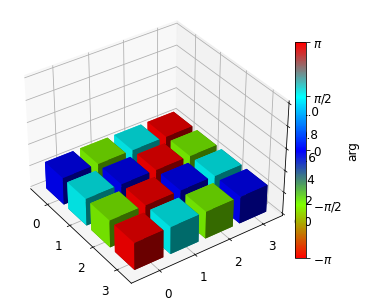

In [181]:
matrix_histogram_complex(Results[test]['Reduce'][3][100])

In [1444]:
Results[test]['Reduce'][1][100]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 7.78386094e-06+0.j         -1.55356940e-05+0.00197272j
  -7.78386094e-06+0.j          1.55356940e-05+0.00197272j]
 [-1.55356940e-05-0.00197272j  4.99992212e-01+0.j
   1.55356940e-05+0.00197272j  4.99930197e-01-0.00787465j]
 [-7.78386094e-06+0.j          1.55356940e-05-0.00197272j
   7.78386094e-06+0.j         -1.55356940e-05-0.00197272j]
 [ 1.55356940e-05-0.00197272j  4.99930197e-01+0.00787465j
  -1.55356940e-05+0.00197272j  4.99992212e-01+0.j        ]]

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x150a3688d30>)

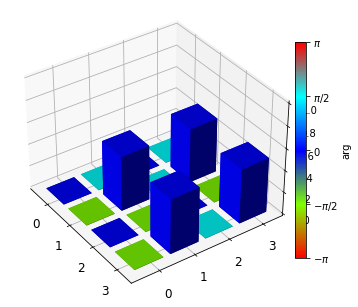

In [1445]:
matrix_histogram_complex(Results[test]['Reduce'][1][100])

In [1198]:
conc([Results['UU']['Reduce'][0][100].unit()])

KeyError: 'UU'

In [1025]:
conc(Results['yy']['Reduce'][2][99:100])

[0.9999999990705929]

In [1045]:
[ket2dm(bell_state(state='00')-bell_state(state='01')).unit()]

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 1.]]]

In [918]:
Results['XX']['Reduce'][0][100]

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.24608925+0.j         -0.00191938+0.24608177j -0.00191938+0.24608177j
   0.24608925+0.j        ]
 [-0.00191938-0.24608177j  0.24608925+0.j          0.24608925+0.j
  -0.00191938-0.24608177j]
 [-0.00191938-0.24608177j  0.24608925+0.j          0.24608925+0.j
  -0.00191938-0.24608177j]
 [ 0.24608925+0.j         -0.00191938+0.24608177j -0.00191938+0.24608177j
   0.24608925+0.j        ]]

(<Figure size 432x288 with 2 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x15085d25d30>)

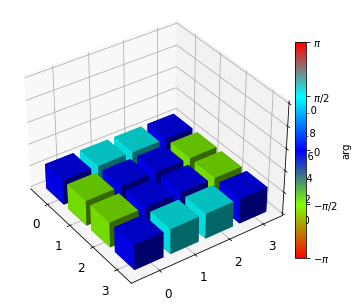

In [785]:
matrix_histogram_complex(reduce[20])

In [ ]:
from IPython import display
%matplotlib inline

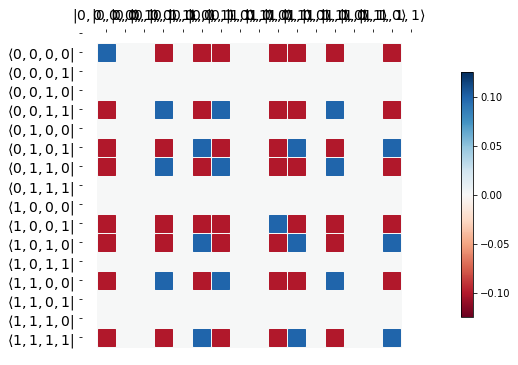

In [521]:
for n in vec:
    clear_output(wait=True)
    rho_c = ket2dm(n)
    hinton(rho_c)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.pause(1)

In [424]:
# rho_c = ket2dm(vec[0])
a =(proj1*rho_c*proj4)
# a = proj1*rho_c

In [426]:
a

Quantum object: dims = [[2, 2, 2, 2], [2, 2, 2, 2]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 0.12500054+0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        -0.12500031j  0.        +0.j          0.        +0.j
   0.        +0.j         -0.12500012+0.j          0.        +0.j
   0.        -0.12500031j  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j  

In [427]:
(a).diag().sum()

(0.25000062887765445+0j)

### Bloch sphere

In [1813]:
start_time = time.time()
#
# set up the calculation
#
solver = "me"   # use the ode solver
#solver = "mc"   # use the monte-carlo solver

N = 3            # number of spins

Sbasis = Qobj([[0],[1],[0]]).unit() #sigmax, sigmay, sigmaz
CorMea = [
            [Sbasis,Sbasis],
            [Sbasis],
            [Qobj([[0],[0],[1]]),Sbasis,Qobj([[0],[0],[1]])],
         ]

Nran = np.random.rand(1)
ResExp = np.empty(len(Nran), dtype=object)
for i,rani in enumerate(Nran):
    if (i+1)%10 == 0:
        print('\r',i+1,end='')
    # array of spin energy splittings and coupling strengths. here we use
    # uniform parameters, but in general we don't have too
    Bx = 0.0 * np.ones(N)
    Bz = 0.0 * np.ones(N)
    Jz = 1.0 * np.ones(N)
    Jx = 0.0 * np.ones(N)
    Jy = 0.0 * np.ones(N)
    
    # dephasing rate
    gamma = 0.00 * np.ones(N)

    # intial state, first spin in state |1>, the rest in state |0>
    psi_list = []
    # psi_list.append((basis(2, 0) + basis(2, 1)).unit())

    for n in range(N):
        # psi_list.append(basis(2,0)) #up |0>
#         psi_list.append((basis(2, 0) + basis(2, 1)).unit()) # |x>
        psi_list.append((basis(2, 0) - 1j*basis(2, 1)).unit()) # |y>

    psi0 = tensor(psi_list)

    tlist = np.linspace(0, 6, 10)
    # 
    ResSta[i] = integrate(N, Bx, Bz, Jx, Jy, Jz, psi0, tlist, gamma, solver, CorMea, StateOut=True)
print("--- %0.4f seconds ---" % (time.time() - start_time))

--- 0.0156 seconds ---


In [1815]:
vec = ResSta[0]
up = basis(2,0)

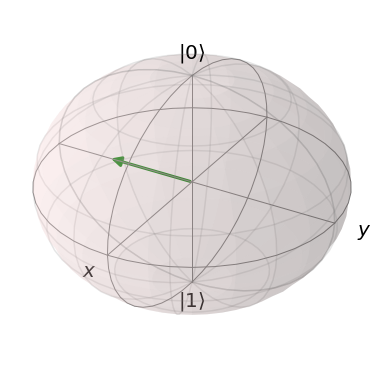

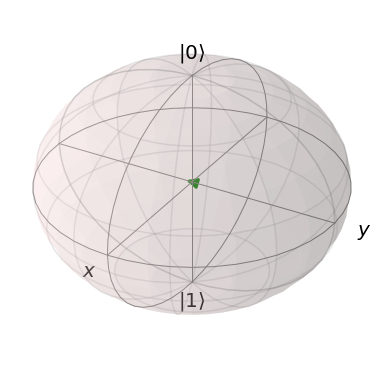

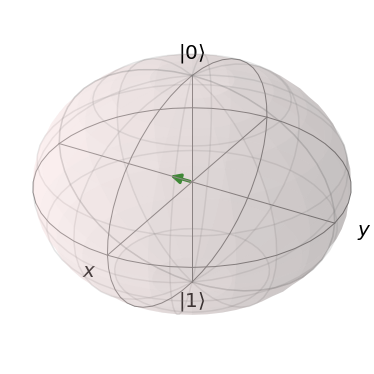

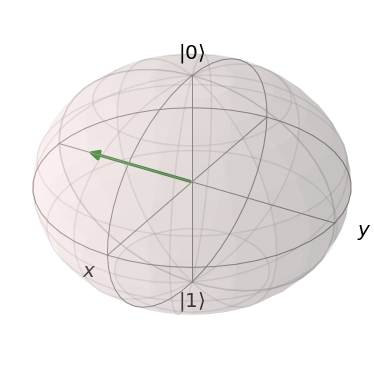

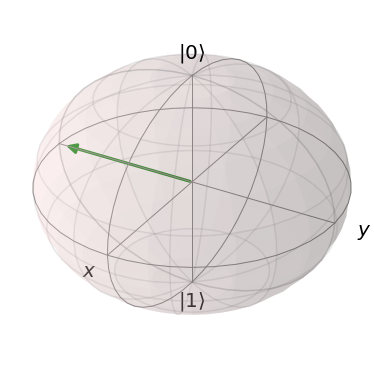

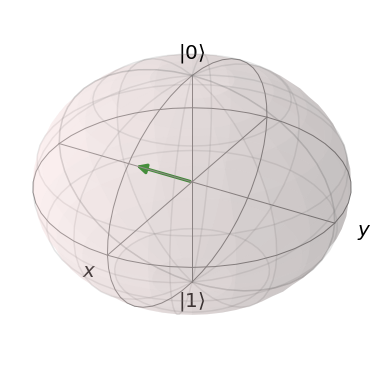

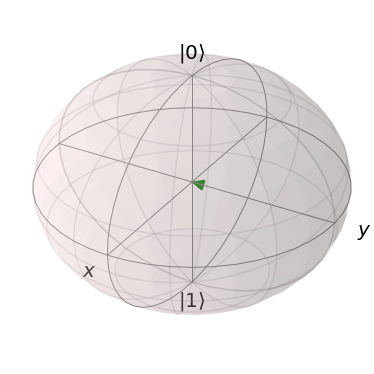

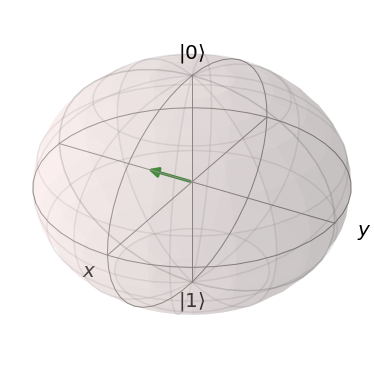

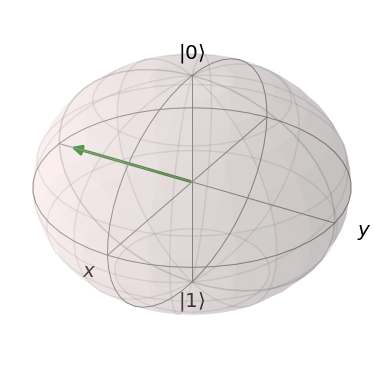

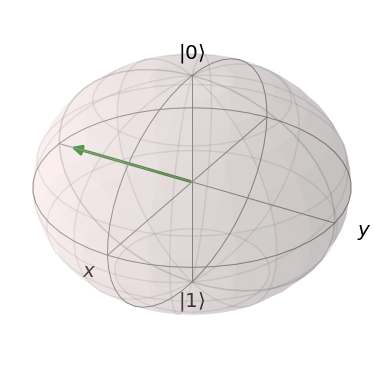

In [1816]:
b = Bloch()
for i in vec:
    b.clear()
    b.add_states(i.ptrace(1))
    b.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ad574db9-57f6-4918-b977-e02cef63b094' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>